## This Notebook is for the evaluation of the two models on the two datasets

- So we have 4 confusion matrix in the Confusion_Matrix folder
- We have one ROC-Curve in the ROC Folder containing all ROC Curves
- We have a metrics.csv where all the results are stored

## 1. Import Libaries

In [1]:
import sys
sys.path.append("..")
# Now you can import your module
from helpers import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from NN import *
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Evaluate the models on test data

In [3]:
model, accuracys, precisions, recalls, f1_scores, auc, fprs, tprs, thresholds = [], [], [], [], [], [], [], [], []

- Use the models to predict the test data and use the confusion matrix and their metrices (accuracy, precision, recall and f1-score)
- perform testing on the saved Neural Network in the Models folder (Model_1 for BP_PHQ_9, Model_0 for MH_PHQ_S)
- Compute the confusion matrix and calculate the accuracy, precision, recall, f1-score and auc
- store these values in the lists

Accuracy:  0.734375
Precision:  0.9130434782608695
Recall:  0.5833333333333334
F1:  0.7118644067796611


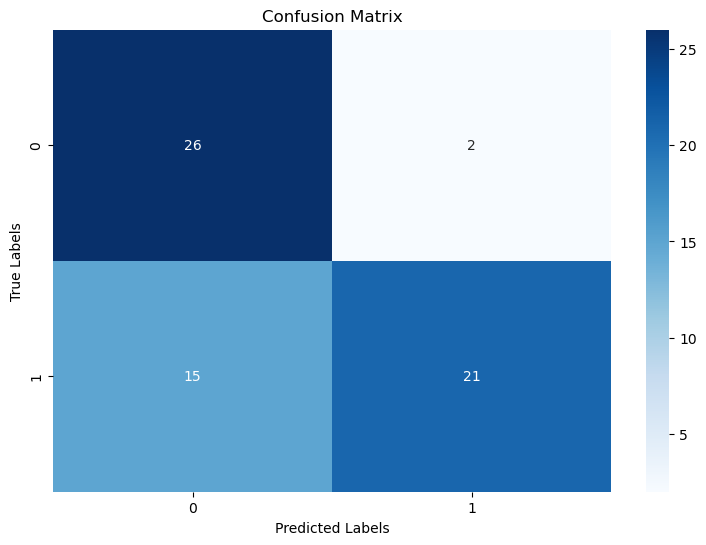

In [4]:
input_size = 56
hidden_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

depression_classifier = 'BP_PHQ_9'

model_phq_9 = Depression_Classifier_v_1(input_size, hidden_size).to(device)
model_phq_9.load_state_dict(torch.load('Models/BP_PHQ_9.pth'))
model_phq_9.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_phq_9, device, depression_classifier)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier)
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))
#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

Do the same for the MH_PHQ_S Classifier

Accuracy:  0.6428571428571429
Precision:  0.5897435897435898
Recall:  0.48936170212765956
F1:  0.5348837209302325


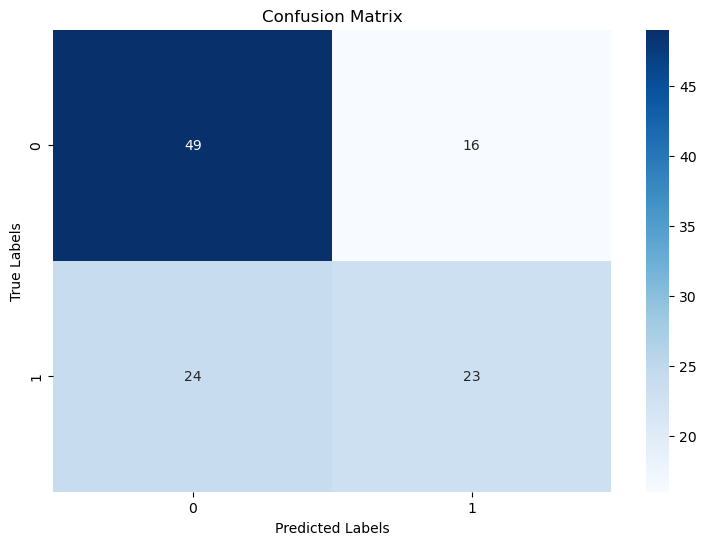

In [5]:
depression_classifier = 'MH_PHQ_S'


model_mh_phq_s = Depression_Classifier_v_2(input_size, hidden_size).to(device)
model_mh_phq_s.load_state_dict(torch.load('Models/MH_PHQ_S.pth'))
model_mh_phq_s.eval()
true_labels_all, predicted_labels_all, predicted_probabilites, TN, FP, FN, TP = evaluate(model_mh_phq_s, device, depression_classifier)


accuracy, precision, recall, f1, FNR = compute_metrics(TN, FP, FN, TP)
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1: ', f1)

model.append('MLP_' + depression_classifier)
accuracys.append(accuracy)
precisions.append(precision)
recalls.append(recall)
f1_scores.append(f1)
# Compute TPR and FPR
fpr, tpr, threshold = roc_curve(true_labels_all, predicted_probabilites)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)
# Calculate AUC (Area Under the Curve)
auc.append(roc_auc_score(true_labels_all, predicted_probabilites))

#auc.append(create_roc(true_labels_all, predicted_probabilites, depression_classifier, sample_version, model_name='MLP'))

Do the evaluation for the Adaboost Algorithm aswell and compute the metrics

Best Performing Hyperparameters
- Adaboost BP_PHQ_9: depth of trees 4, number of trees 70, learning rate 0.3
- Adaboost MH_PHQ_S: depth of trees 3, number of trees 80, learning rate 0.6

Accuracy:  0.671875
Precision:  0.6923076923076923
Recall:  0.75
F1:  0.7199999999999999
Accuracy:  0.71875
Precision:  0.725
Recall:  0.8055555555555556
F1:  0.7631578947368423


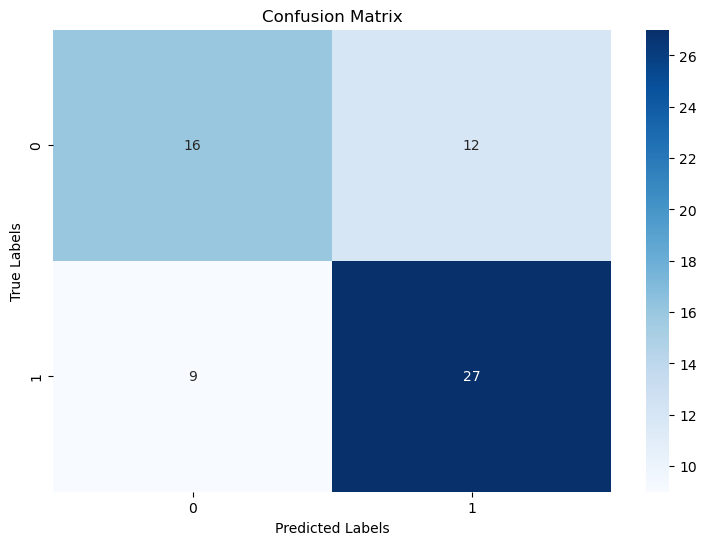

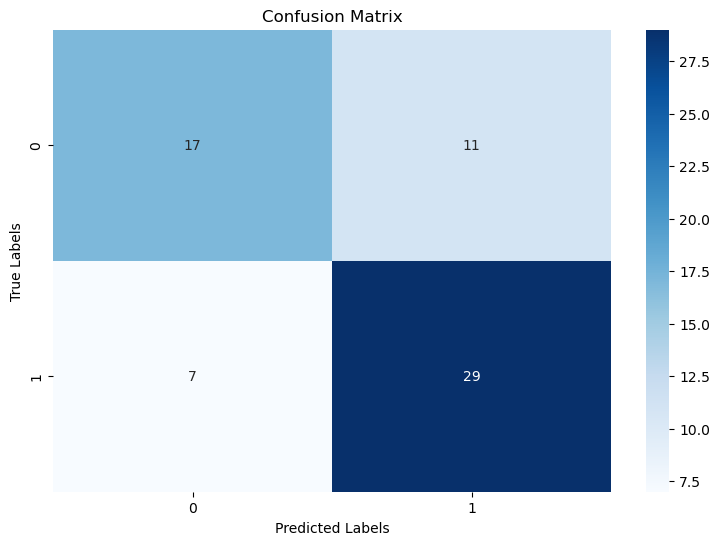

In [6]:
depression_classifiers = ['BP_PHQ_9','MH_PHQ_S']


#Using the optimal hyperparameters to get metrices and scores
learning_rates = [0.3,0.6]
depth = [4,3]
n_estimators = [70,80]

for i in range(2):
    if depression_classifiers[i] == 'BP_PHQ_9':
            df = pd.read_csv('../data/Threshold_3_Operator_-_Depressionfeature_BP_PHQ_9_PercentofDataset_100.csv')
    elif depression_classifier[i] == 'MH_PHQ_S':
            df = pd.read_csv('../data/Threshold_15_Operator_-_Depressionfeature_MH_PHQ_S_PercentofDataset_100.csv')
      
    features = []
    targets = []
    for indx, row in df.iterrows():
        feature = []
        for column in df.columns:
            if 'FEATURE' in column:
                feature.append(row[column])
        features.append(feature)
        targets.append(row['Depression'])

    features = np.array(features, dtype=np.float32)
    targets = np.array(targets, dtype=np.int16)

    X_train, X_test, y_train, y_test = train_test_split(features,targets, test_size=0.1, random_state=42)

    base_estimator = DecisionTreeClassifier(max_depth=depth[i])
    ada_boost = AdaBoostClassifier(estimator=base_estimator, n_estimators=n_estimators[i], learning_rate=learning_rates[i], random_state=42)
    ada_boost.fit(X_train, y_train)
    y_pred = ada_boost.predict(X_test)
    predicted_probabilites = ada_boost.predict_proba(X_test)[:,1]

    #Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig(f'Confusion_Matrix/Confusion_Matrix_Adaboost_{depression_classifiers[i]}.png')

    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN) # True positive rate
    FNR = FN / (TP + FN) # False negative rate
    f1 = 2 * (precision * recall) / (precision + recall)

    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1: ', f1)
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    model.append('AdaBoost_' + depression_classifiers[i])
    # Compute TPR and FPR
    fpr, tpr, threshold = roc_curve(y_test, predicted_probabilites)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    # Calculate AUC (Area Under the Curve)
    auc.append(roc_auc_score(y_test, predicted_probabilites))
    #auc.append(create_roc(y_pred, predicted_probabilites, depression_classifier, sample_version, model_name='AdaBoost'))
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


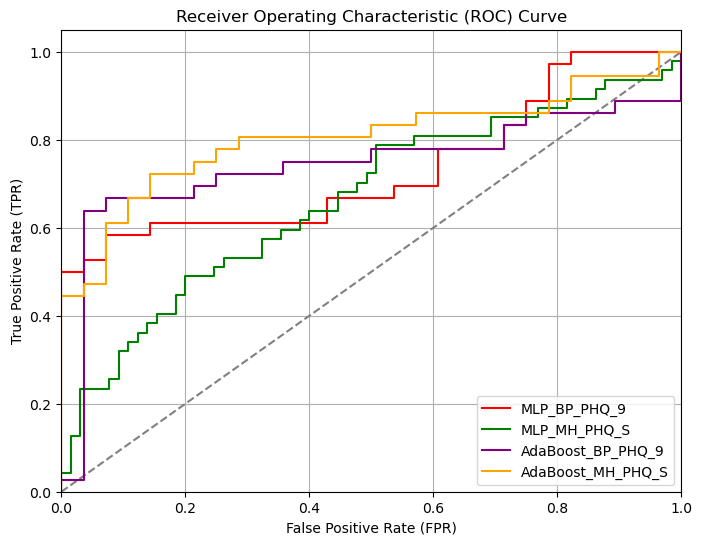

In [7]:
create_roc(fprs, tprs, model)

- The recall is really important here, because we want to detect as many people with depression as possible (TP+FN)
- The F1 Score is important aswell, because of the imbalanced dataset

In [8]:
df = pd.DataFrame({'Model': model, 'Accuracy': accuracys, 'Precision': precisions, 'Recall': recalls, 'F1': f1_scores, 'AUC': auc,})

In [9]:
df.to_csv('Results/Metrics.csv', index=False)